In [1]:
cd ..

/home/studio-lab-user/sagemaker-studiolab-notebooks


In [2]:
cd openmic-2018

/home/studio-lab-user/sagemaker-studiolab-notebooks/openmic-2018


In [3]:
import json
import os
import numpy as np
#!pip install pandas
import pandas as pd
import tensorflow as tf

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import multilabel_confusion_matrix, classification_report

2022-10-31 15:14:33.779187: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-31 15:14:34.983195: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-10-31 15:14:34.983268: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-10-31 15:14:34.983276: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make su

In [4]:
data = np.load("openmic-2018.npz", allow_pickle = True)
X, Y_true, Y_mask, sample_key = data['X'], data['Y_true'], data['Y_mask'], data['sample_key']
print(X.shape, Y_true.shape, Y_mask.shape, sample_key.shape)

(20000, 10, 128) (20000, 20) (20000, 20) (20000,)


In [5]:
print(Y_true[0])
Y_true1 = np.where(Y_true > 0.5, 1, 0)
print(Y_true1[0])

[0.5     0.5     0.5     0.5     0.17105 0.5     0.5     0.      0.5
 0.5     0.5     0.5     0.5     0.5     0.5     0.5     0.      0.5
 0.5     0.5    ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [6]:
IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model

In [7]:
def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

In [8]:
BATCH_SIZE = 32 # Big enough to measure an F1-score
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically to reduce GPU and CPU idle time
SHUFFLE_BUFFER_SIZE = 128 # Shuffle the training data by a chunck of 128 observations

In [9]:
def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
    # if is_training == True:
    #     # This is a small dataset, only load it once, and keep it in memory.
    #     dataset = dataset.cache()
    # Shuffle the data each buffer size
    # dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [10]:
# PROLLY DONT NEED THIS
# Load training split csv file
with open("partitions/split01_train.csv") as f:
    train_IDs = f.readlines()
    train_IDs = np.array([ID.strip() for ID in train_IDs])
print(train_IDs.shape)

# Load test split csv file
with open("partitions/split01_test.csv") as f:
    test_IDs = f.readlines()
    test_IDs = np.array([ID.strip() for ID in test_IDs])
print(test_IDs.shape)

# Get the training and testing split data into np arrays
# Creates an array, which contains the index of the sample in data.  
train_index = np.array([i for i in range(20000) if sample_key[i] in train_IDs])
test_index = np.array([i for i in range(20000) if sample_key[i] in test_IDs])

print(train_index.shape)
print(test_index[1:10])

(14915,)
(5085,)
(14915,)
[29 30 31 32 33 34 35 36 37]


In [11]:
train_paths = [f"/home/studio-lab-user/sagemaker-studiolab-notebooks/openmic-2018/audio-logmel/{i[:3]}/{i}.png" for i in train_IDs]
print(train_paths[1])

test_paths = [f"/home/studio-lab-user/sagemaker-studiolab-notebooks/openmic-2018/audio-logmel/{i[:3]}/{i}.png" for i in test_IDs]
print(test_paths[1])

train_labels = [Y_true1[i] for i in train_index]
print(train_labels[1])

test_labels = [Y_true1[i] for i in test_index]
print(test_labels[1])

/home/studio-lab-user/sagemaker-studiolab-notebooks/openmic-2018/audio-logmel/000/000135_483840.png
/home/studio-lab-user/sagemaker-studiolab-notebooks/openmic-2018/audio-logmel/000/000308_61440.png
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [12]:
x_train = create_dataset(train_paths, train_labels)
print(x_train)

x_test = create_dataset(test_paths, test_labels)
print(x_test)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.int64, name=None))>


In [13]:
for element in x_train.as_numpy_iterator():
    print(element[1].shape)
    break

(32, 20)


In [14]:
# import necessary layers  
from tensorflow.keras.layers import Input, Conv2D 
from tensorflow.keras.layers import MaxPool2D, Flatten, Dense 
from tensorflow.keras import Model
# input

input = Input(shape =(224,224,3))
# 1st Conv Block
x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(input)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

# 2nd Conv Block
x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

# 3rd Conv block
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

# 4th Conv block
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

# Fully connected layers
x = Flatten()(x)
x = Dense(units = 4096, activation ='relu')(x)
x = Dense(units = 4096, activation ='relu')(x)
output = Dense(units = 20, activation ='sigmoid')(x)

# creating the model

model = Model (inputs=input, outputs =output)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 256)       295168

In [15]:
LR = 1e-5 # Keep it small when transfer learning
EPOCHS = 1
loss_fn = tf.keras.losses.BinaryCrossentropy()

In [16]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss=loss_fn, metrics = ['Recall', 'Precision'])

In [17]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

history = model.fit(x_train, epochs = EPOCHS, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_data = x_test)

467/467 [==============================] - 144s 291ms/step - loss: 0.1895 - recall: 0.0033 - precision: 0.0558 - val_loss: 0.1725 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 1.0000e-05


In [18]:
pwd

'/home/studio-lab-user/sagemaker-studiolab-notebooks/openmic-2018'

In [20]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


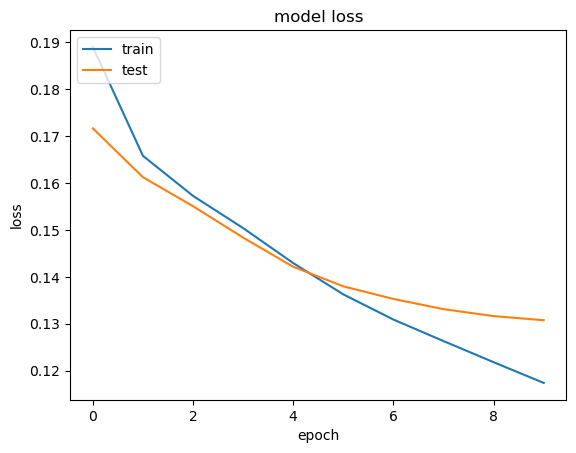

In [21]:
import matplotlib.pyplot as plt
# # summarize history for accuracy
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [38]:
y_pred = model.predict(x_test, batch_size = 1)
print(y_pred[0])
y_pred1 = np.where(y_pred > 0.5, 1, 0)
print(y_pred1[0])

159/159 [==============================] - 10s 61ms/step
[1.6167968e-03 2.5794338e-02 4.9136966e-03 4.9404193e-02 3.0746299e-04
 3.3321609e-03 1.4108956e-02 1.3975517e-03 4.3275943e-03 1.0633381e-02
 3.5684246e-03 9.3950797e-03 1.4575036e-03 5.7879407e-03 1.2917244e-02
 4.6461592e-03 1.3817917e-03 4.0855426e-03 7.7922181e-03 4.9381122e-01]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [39]:
print(multilabel_confusion_matrix(test_labels, y_pred1))

[[[4940   30]
  [ 102   13]]

 [[4925   20]
  [ 135    5]]

 [[4927   24]
  [ 115   19]]

 [[4782   77]
  [ 162   64]]

 [[4945    3]
  [ 136    1]]

 [[4721   67]
  [ 204   93]]

 [[4753   54]
  [ 179   99]]

 [[4876   34]
  [ 146   29]]

 [[4767   32]
  [ 238   48]]

 [[4871    3]
  [ 209    2]]

 [[4870   22]
  [ 173   20]]

 [[4960    4]
  [ 121    0]]

 [[4789   11]
  [ 202   83]]

 [[4757   23]
  [ 269   36]]

 [[4767   50]
  [ 200   68]]

 [[4856    1]
  [ 228    0]]

 [[4764    3]
  [ 313    5]]

 [[4870   33]
  [ 132   50]]

 [[4574  117]
  [ 223  171]]

 [[4854    7]
  [ 193   31]]]


In [41]:
print(classification_report(test_labels, y_pred1))

              precision    recall  f1-score   support

           0       0.30      0.11      0.16       115
           1       0.20      0.04      0.06       140
           2       0.44      0.14      0.21       134
           3       0.45      0.28      0.35       226
           4       0.25      0.01      0.01       137
           5       0.58      0.31      0.41       297
           6       0.65      0.36      0.46       278
           7       0.46      0.17      0.24       175
           8       0.60      0.17      0.26       286
           9       0.40      0.01      0.02       211
          10       0.48      0.10      0.17       193
          11       0.00      0.00      0.00       121
          12       0.88      0.29      0.44       285
          13       0.61      0.12      0.20       305
          14       0.58      0.25      0.35       268
          15       0.00      0.00      0.00       228
          16       0.62      0.02      0.03       318
          17       0.60    

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
